##  ДЗ Урок 2. 
### Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.corpora.dictionary import Dictionary

#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

import nltk

from gensim.models import LdaModel
from gensim.test.utils import datapath

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [2]:
news = pd.read_csv("articles.csv")

In [3]:
users = pd.read_csv("users_articles.csv")

### 1. Получаем векторные представления новостей

In [6]:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Svet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt',encoding="utf8") as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\Svet\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


Wall time: 27.9 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 59s


In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

### сделаем TfidfVectorizer и получим idf коэффициенты для новостей

In [16]:
texts_for_idf = [" ".join(t) for t in texts]

In [17]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts_for_idf)
idf = vectorizer.idf_


In [18]:
# сделаем словарь {слово:вес}
d = dict(zip(vectorizer.get_feature_names(), idf))


In [20]:
# посчитаем коэффициенты idf для новостей

# вот тут я не поняла как их считать??? сделала просто как сумма idf слов из новости

idf_doc = []
for i in range(len(texts)):
    s = 0
    for w in texts[i]:
        try:
            s = s + d[w]
        except KeyError:
#             print(w)
            s = s + 0
    idf_doc.append(s)

In [21]:
idf_doc[:3]

[553.5394943729019, 195.90825608334396, 205.20895067057066]

In [22]:
texts_for_idf[:3]

['заместитель председатель правительство рф сергей иванов избрать председатель совет пбк цска прессслужба армеец решение единогласно принять первый заседание совет клуб основной функция орган обсуждение текущий состояние планирование утверждение стратегия развитие клуб близкий перспектива nn состав совет войти георгий полтавченко полномочный центральный федеральный округ алексей седов генералполковник начальник служба защита конституционный строй борьба терроризм фсб рф nn александр новак заместитель министр финансы рф вячеслав полтавец заместитель генеральный директор руководитель блок взаимодействие орган власть социальный корпоративный политика гмк норильский никель nn леонид исакович генеральный директор ооо ук спортивный проект ольга плешаков генеральный директор трансаэро nn александр провоторов генеральный директор оао ростелеком андрей лопат эксигрок цска чемпион мир трёхкратный чемпион европа баскетбол председатель правление банк клиентский nn андрей ватутин пбк цска',
 'матч 

In [23]:
# сделаем словарь {doc_id : idf_doc}
idf_doc_id = dict(zip(news.doc_id, idf_doc))
# idf_doc_id

Запускаем обучение

In [24]:

# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

In [25]:

# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [26]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

# unseen_doc = other_corpus[2]
# print(other_texts[2])
# lda[unseen_doc] 

In [27]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 

for topic,words in topics_words:
    print(f'topic_{topic}: {" ".join(words)}')

topic_0: санкция путин российский россия владимир банк глава
topic_1: северный южный япония корея употребление акционер ким
topic_2: газ фонд россия агентство российский поток товар
topic_3: турция планета живой захватить источник лодка земля
topic_4: сша американский экономический белоруссия россия экономика российский
topic_5: тело район пострадать взрыв произойти обнаружить земля
topic_6: мероприятие конкурс nn сайт участник физика состояться
topic_7: рост большой вырасти спрос составить топливо наиболее
topic_8: nn область поверхность nnn остров км первый
topic_9: россиянин снижение производить польша оплата озеро место
topic_10: закон рубль законопроект депутат налоговый уголовный преступление
topic_11: день первый nn объект исследование век всё
topic_12: исследование ребёнок сша писать власть женщина пациент
topic_13: россия новый российский система проект развитие военный
topic_14: гражданин активность доклад фронт народный предприниматель бизнесмен
topic_15: болезнь операция ii

In [28]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [29]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.780092,0.0,0.0,0.000000,0.0,0.000000,0.103655,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1,4896,0.000000,0.0,0.0,0.000000,0.0,0.295251,0.288551,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.393024,0.000000,0.000000,0.0,0.000000,0.0
2,4897,0.000000,0.0,0.0,0.057942,0.0,0.000000,0.250698,0.289835,0.280003,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.021819,0.0
3,4898,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.124560,0.000000,0.000000,...,0.0,0.0,0.0,0.163419,0.000000,0.015677,0.103583,0.0,0.000000,0.0
4,4899,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.190795,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.782120,0.000000,0.000000,0.0,0.000000,0.0


### Следующий шаг - векторные представления пользователей

In [30]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

## Mean - усреднение

In [140]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [141]:
get_user_embedding(user_articles_list)

array([0.15056594, 0.        , 0.        , 0.        , 0.04057183,
       0.0017218 , 0.0275241 , 0.04303685, 0.00528581, 0.00920135,
       0.08714914, 0.02450678, 0.06165116, 0.1269192 , 0.01340682,
       0.00220873, 0.01336796, 0.04631492, 0.10204312, 0.07967343,
       0.00521268, 0.13626512, 0.        , 0.00452579, 0.00456869])

In [142]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
# user_embeddings.head(3)

In [143]:
target = pd.read_csv("users_churn.csv")
# target.head(3)

In [144]:
X = pd.merge(user_embeddings, target, 'left')
# X.head(3)

In [145]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [146]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

C:\Users\Svet\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [147]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
# preds[:10]

### Рассчитаем Precision, Recall, F_score для mean-усреднения

In [148]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.248780, F-Score=0.686, Precision=0.626, Recall=0.759


In [149]:
# сохраним значения метрик для сравнения разных усреднений
precision_total = []
recall_total = []
fscore_total = []
thresholds_total = []

precision_total.append(precision[ix])
recall_total.append(recall[ix])
fscore_total.append(fscore[ix])
thresholds_total.append(thresholds[ix])

In [150]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1644  111]
 [  60  185]]


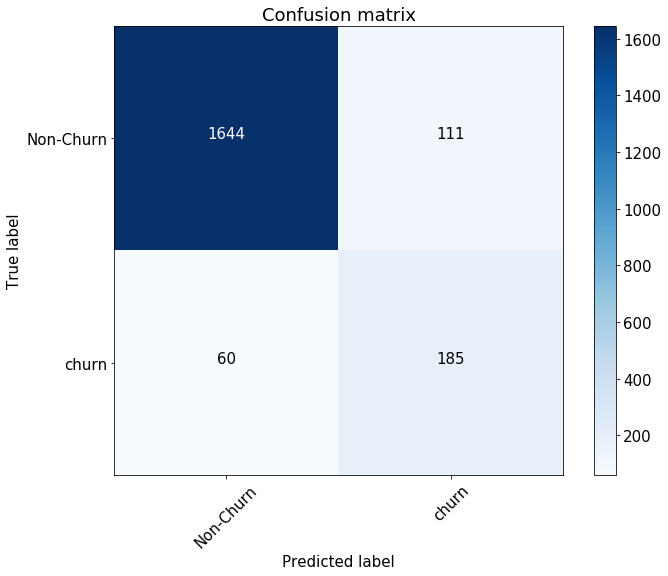

In [151]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [152]:
roc_auc_total = []
roc_auc_total.append(roc_auc_score(y_test, preds))
roc_auc_total[0]

0.9513250770393628

## Median-усреднение

In [153]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [154]:
get_user_embedding(user_articles_list)

array([0.06562818, 0.        , 0.        , 0.        , 0.03731518,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03039192, 0.        , 0.04488498, 0.09797528, 0.00652973,
       0.        , 0.        , 0.        , 0.04767444, 0.06117008,
       0.        , 0.14641947, 0.        , 0.        , 0.        ])

In [155]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
# user_embeddings.head(3)

In [156]:
target = pd.read_csv("users_churn.csv")
# target.head(3)

In [157]:
X = pd.merge(user_embeddings, target, 'left')
# X.head(3)

In [158]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [159]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

C:\Users\Svet\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [160]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
# preds[:10]

### Рассчитаем Precision, Recall, F_score для median-усреднения

In [161]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.293453, F-Score=0.776, Precision=0.781, Recall=0.771


In [162]:
roc_auc_total.append(roc_auc_score(y_test, preds))
roc_auc_total[1]

0.967049247049247

In [163]:
precision_total.append(precision[ix])
recall_total.append(recall[ix])
fscore_total.append(fscore[ix])
thresholds_total.append(thresholds[ix])

Confusion matrix, without normalization
[[1702   53]
 [  57  188]]


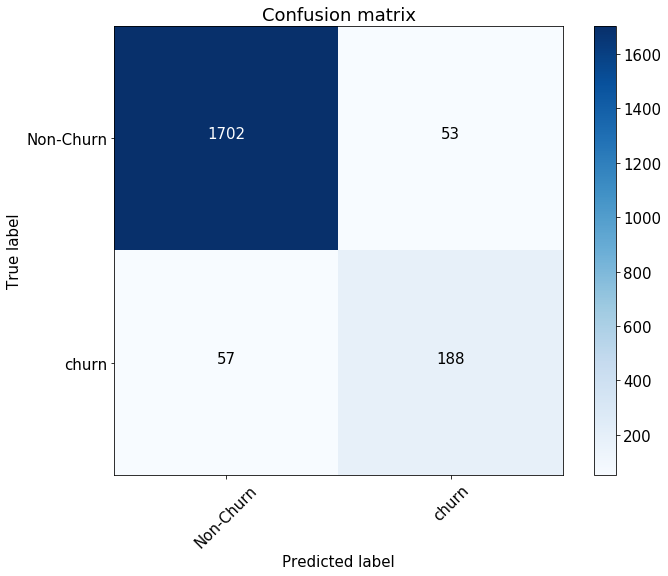

In [164]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

## Max-усреднение

In [165]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [166]:
get_user_embedding(user_articles_list)

array([0.50444692, 0.        , 0.        , 0.        , 0.09109927,
       0.01033079, 0.12561992, 0.1887996 , 0.03171484, 0.05520809,
       0.30237213, 0.14704067, 0.21097247, 0.31462976, 0.0490952 ,
       0.01325236, 0.0532381 , 0.27788952, 0.31948203, 0.23345712,
       0.03127608, 0.31737611, 0.        , 0.02715475, 0.02741217])

In [167]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
# user_embeddings.head(3)

In [168]:
target = pd.read_csv("users_churn.csv")
# target.head(3)

In [169]:
X = pd.merge(user_embeddings, target, 'left')
# X.head(3)

In [170]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [171]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

C:\Users\Svet\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [172]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
# preds[:10]

### Рассчитаем Precision, Recall, F_score для max-усреднения

In [173]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.403964, F-Score=0.792, Precision=0.854, Recall=0.739


In [174]:
roc_auc_total.append(roc_auc_score(y_test, preds))
roc_auc_total[2]

0.9779987208558637

In [175]:
precision_total.append(precision[ix])
recall_total.append(recall[ix])
fscore_total.append(fscore[ix])
thresholds_total.append(thresholds[ix])

Confusion matrix, without normalization
[[1724   31]
 [  65  180]]


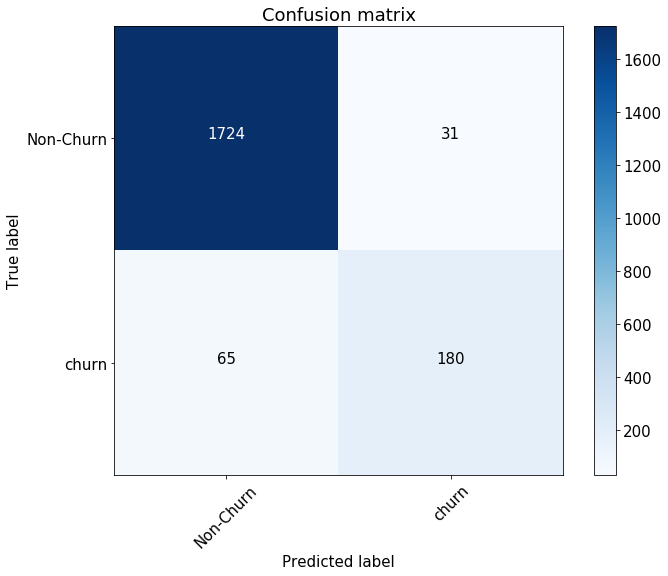

In [176]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

## Mean_idf-усреднение

In [177]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id]*idf_doc_id[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [178]:
get_user_embedding(user_articles_list)

array([ 62.5466092 ,   0.        ,   0.        ,   0.        ,
        96.3310941 ,  10.78600304,  11.60711212,  90.78356908,
        33.1123186 ,   5.35212758,  35.61329725, 153.51985566,
        89.13820745, 366.59037412,   6.55386606,   0.98213304,
         6.39564654,  17.20033016,  79.18936956, 114.75020576,
         1.43161752, 161.25407664,   0.        ,   2.63250677,
        28.62005479])

In [179]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,32.424110,0.0,2.659798,21.454162,7.228514,50.853552,34.326563,16.764288,32.016195,...,1.566120,26.255017,29.533376,34.125117,33.846822,0.000000,75.178458,32.366583,3.173738,8.104216
1,u108690,104.175356,0.0,4.989038,8.929907,51.341908,60.190595,26.167269,40.248943,58.163186,...,6.088637,20.832293,19.390760,212.804273,179.320738,29.124735,404.846414,14.898866,0.000000,13.517980
2,u108339,118.871251,0.0,48.732641,0.000000,75.769264,182.025998,20.591044,37.492691,165.874532,...,2.226160,43.330794,71.361604,146.553262,246.818660,7.642811,146.148846,25.230171,0.000000,3.229752


In [180]:
target = pd.read_csv("users_churn.csv")
# target.head(3)

In [181]:
X = pd.merge(user_embeddings, target, 'left')
# X.head(3)

In [182]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [183]:
logreg = LogisticRegression()
#обучим наш пайплайн
logreg.fit(X_train, y_train)

C:\Users\Svet\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [184]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
# preds[:10]

### Рассчитаем Precision, Recall, F_score для idf_mean-усреднения

In [185]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.509297, F-Score=0.978, Precision=0.968, Recall=0.988


In [186]:
roc_auc_total.append(roc_auc_score(y_test, preds))
roc_auc_total[3]

0.9983161811733241

In [187]:
precision_total.append(precision[ix])
recall_total.append(recall[ix])
fscore_total.append(fscore[ix])
thresholds_total.append(thresholds[ix])

Confusion matrix, without normalization
[[1747    8]
 [   4  241]]


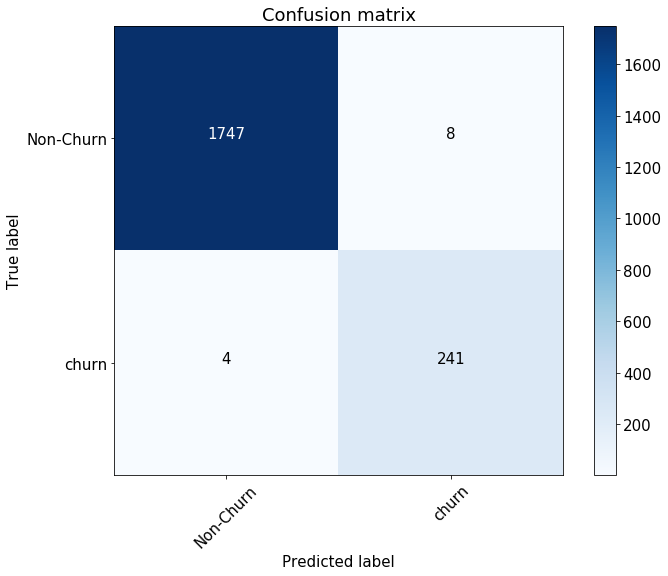

In [188]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [189]:
total_metrics = pd.DataFrame(
                            {'precision' : precision_total,
                             'recall' : recall_total,
                             'f_score' : fscore_total,
                             'roc_auc_score' : roc_auc_total},
                            index = ['mean', 'median', 'max', 'mean_idf'])

In [190]:
total_metrics

,precision,recall,f_score,roc_auc_score
mean,0.626263,0.759184,0.686347,0.951325
median,0.780992,0.771429,0.776181,0.967049
max,0.853774,0.738776,0.792123,0.977999
mean_idf,0.968000,0.987755,0.977778,0.998316


как видно из таблицы, лучше всего сработало среднее взвешенное.